[View in Colaboratory](https://colab.research.google.com/github/ayoyu/Convolutional-Neural-Networks-with-tensorflow/blob/master/CNN_Tensorflow.ipynb)

In [0]:
import tensorflow as tf
import numpy as np
import os

class CNN(object):
    
    def __init__(self,epochs,batch_size,nbr_classes,n_features,learning_rate,dropout_rate,shuffle=True,random_seed=None):
        self.epochs=epochs
        self.batch_size=batch_size
        self.nbr_classes=nbr_classes
        self.n_features=n_features
        self.learning_rate=learning_rate
        self.dropout_rate=dropout_rate
        self.shuffle=shuffle
        self.random_seed=random_seed
        g=tf.Graph()
        with g.as_default():
            tf.set_random_seed(self.random_seed)
            self.build()
            self.init=tf.global_variables_initializer()
            self.saver=tf.train.Saver()
        self.sess=tf.Session(graph=g)
    
    def build(self):
        self.X=tf.placeholder(dtype=tf.float32,shape=(None,self.n_features),name='input')
        self.y=tf.placeholder(dtype=tf.int32,shape=(None),name='output')
        self.is_train=tf.placeholder(tf.bool,shape=(),name='is_train')
        X_images=tf.reshape(self.X,shape=[-1,28,28,1],name='images')
        y_onehot=tf.one_hot(indices=self.y,depth=self.nbr_classes,name='y_onehot')
        conv1=tf.layers.conv2d(inputs=X_images,filters=32,kernel_size=(5,5),
                               padding='valid',activation=tf.nn.relu)
        max_pool1=tf.layers.max_pooling2d(inputs=conv1,pool_size=(2,2),strides=(2,2))
        conv2=tf.layers.conv2d(inputs=max_pool1,filters=64,kernel_size=(5,5),
                               padding='valid',activation=tf.nn.relu)
        max_pool2=tf.layers.max_pooling2d(inputs=conv2,pool_size=(2,2),strides=(2,2))
        inputs_shape=max_pool2.get_shape().as_list()
        inputs_units=np.prod(inputs_shape[1:])
        pool_flatten=tf.reshape(max_pool2,shape=[-1,inputs_units])
        fully_connected1=tf.layers.dense(inputs=pool_flatten,units=1024,activation=tf.nn.relu)
        dropout1=tf.layers.dropout(inputs=fully_connected1,rate=self.dropout_rate,training=self.is_train)
        fully_connected2=tf.layers.dense(inputs=dropout1,units=self.nbr_classes,activation=None)
        
        self.predictions={'proba':tf.nn.softmax(logits=fully_connected2),
                     'labels':tf.cast(tf.argmax(fully_connected2,axis=1),dtype=tf.int32,name='labels')}
        
        self.loss_function=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_onehot,
                                                                             logits=fully_connected2,name='cross_entropy_loss'))
        self.optimzer=tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(loss=self.loss_function,name='optimizer')
        
        correct_predictions=tf.equal(self.y,self.predictions['labels'])
        self.accuracy=tf.reduce_mean(tf.cast(correct_predictions,dtype=tf.float32),name='accuracy')
    
    def save_model(self,epoch,path='./model_CNN/'):
        if os.path.isdir(path):
            os.makedirs(path)
        print('save the model in {}'.format(path))
        self.saver.save(self.sess,os.path.join(path,'model.ckpt'),global_step=epoch)
    
    def load(self,epoch,path):
        print('loading model from {}'.format(path))
        self.saver.restore(self.sess,os.path.join(path,'model.ckpt{}'.format(epoch)))
    
    def batch_generator(self,X_train,y_train):
        X_copy=np.array(X_train,copy=True)
        y_copy=np.array(y_train,copy=True)
        data=np.column_stack((X_copy,y_copy))
        if self.shuffle:
            np.random.shuffle(data)
        X_copy=data[:,:-1]
        y_copy=data[:,-1]
        for i in range(0,X_train.shape[0],self.batch_size):
            yield(X_copy[i:i+self.batch_size,:],y_copy[i:i+self.batch_size])
    
    def fit(self,X,y):
        self.sess.run(self.init)
        self.train_cost=[]
        for epoch in range(self.epochs):
            cost_batch=[]
            for X_batch,y_batch in self.batch_generator(X,y):
                feed_dict={self.X:X_batch,self.y:y_batch,self.is_train:True}
                _,loss=self.sess.run([self.optimzer,self.loss_function],feed_dict=feed_dict)
                cost_batch.append(loss)
            self.train_cost.append(np.mean(cost_batch))
            print('epoch={} \\ loss={}'.format(epoch,np.mean(cost_batch)))
    
    def predict(self,X_test,return_proba=True):
        feed_dict={self.X:X_test,self.is_train:False}
        if return_proba:
            return self.sess.run(self.predictions['proba'],feed_dict=feed_dict)
        else:
            return self.sess.run(self.predictions['labels'],feed_dict=feed_dict)
    

In [4]:
from keras.datasets import mnist
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()
print("images train shape:{}".format(train_images.shape))
print("labels train shape:{}".format(train_labels.shape))
print("images test shape:{}".format(test_images.shape))
print("labels test shape:{}".format(test_labels.shape))

images train shape:(60000, 28, 28)
labels train shape:(60000,)
images test shape:(10000, 28, 28)
labels test shape:(10000,)


images train shape:(60000, 784)
images test shape:(10000, 784)


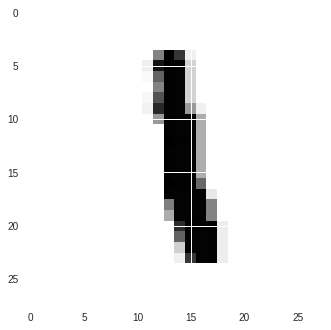

In [7]:
import matplotlib.pyplot as plt
train_images=np.reshape(train_images,(60000,28*28))
test_images=np.reshape(test_images,(10000,28*28))
print("images train shape:{}".format(train_images.shape))
print("images test shape:{}".format(test_images.shape))
index=6
plt.imshow(train_images[index].reshape(28,28))

In [9]:
nbr_classes=np.unique(train_labels).shape[0]
CNN_model=CNN(epochs=20,batch_size=60,nbr_classes=nbr_classes,n_features=train_images.shape[1],learning_rate=0.01,dropout_rate=0.5,shuffle=True,random_seed=10)
CNN_model.fit(train_images,train_labels)

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See tf.nn.softmax_cross_entropy_with_logits_v2.

epoch=0 \ loss=1.908595085144043
epoch=1 \ loss=0.27918946743011475
epoch=2 \ loss=0.3200913071632385
epoch=3 \ loss=0.3106599748134613
epoch=4 \ loss=0.3071245849132538
epoch=5 \ loss=0.30686867237091064
epoch=6 \ loss=0.31252703070640564
epoch=7 \ loss=0.32444819808006287
epoch=8 \ loss=0.3237484097480774
epoch=9 \ loss=0.33554786443710327
epoch=10 \ loss=0.4399779140949249
epoch=11 \ loss=0.37492120265960693
epoch=12 \ loss=0.33805713057518005
epoch=13 \ loss=0.3207647204399109
epoch=14 \ loss=0.3167080581188202
epoch=15 \ loss=0.30852848291397095
epoch=16 \ loss=0.30370599031448364
epoch=17 \ loss=0.29595908522605896
epoch=18 \ loss=0.28732356429100037
epoch=19 \ loss=0.2887123227119446


Text(0.5,1,'Learning curve')

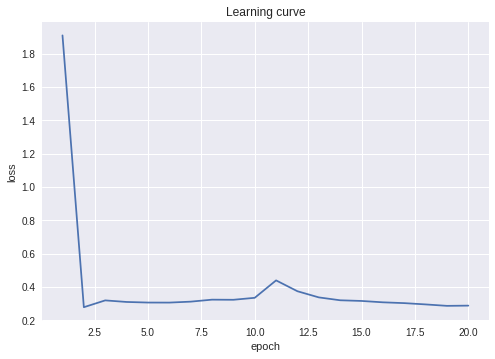

In [10]:
train_cost=CNN_model.train_cost
plt.plot(range(1,len(train_cost)+1),train_cost)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.title("Learning curve")